## Analisys of order delivery dataset

In [212]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from datetime import datetime
from collections import Counter

## Data loading

Dataset comes from Kaggle and it consists of 21 321 food orders from 6 different restaurants (The Chicken Junction, Aura Pizzas, Masala Junction, Tandoori Junction, Swaad, Dilli Burger Adda). It has 29 columns tracking everything from order to feedback.

In [213]:
data=pd.read_csv("../data/raw/order_history_kaggle_data.csv")

We start by loading the raw dataset and inspecting its structure.  
At this stage we look for:
- missing values  
- inconsistent formatting (e.g., inconsistent city names)  
- incorrect data types
- duplicates

In [214]:
print("Dataset shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nDatatypes:", data.dtypes)
print("\nFirst look:")
data.head()

Dataset shape: (21321, 29)

Columns: ['Restaurant ID', 'Restaurant name', 'Subzone', 'City', 'Order ID', 'Order Placed At', 'Order Status', 'Delivery', 'Distance', 'Items in order', 'Instructions', 'Discount construct', 'Bill subtotal', 'Packaging charges', 'Restaurant discount (Promo)', 'Restaurant discount (Flat offs, Freebies & others)', 'Gold discount', 'Brand pack discount', 'Total', 'Rating', 'Review', 'Cancellation / Rejection reason', 'Restaurant compensation (Cancellation)', 'Restaurant penalty (Rejection)', 'KPT duration (minutes)', 'Rider wait time (minutes)', 'Order Ready Marked', 'Customer complaint tag', 'Customer ID']

Datatypes: Restaurant ID                                           int64
Restaurant name                                        object
Subzone                                                object
City                                                   object
Order ID                                                int64
Order Placed At                      

,Restaurant ID,Restaurant name,Subzone,City,Order ID,Order Placed At,Order Status,Delivery,Distance,Items in order,...,Rating,Review,Cancellation / Rejection reason,Restaurant compensation (Cancellation),Restaurant penalty (Rejection),KPT duration (minutes),Rider wait time (minutes),Order Ready Marked,Customer complaint tag,Customer ID
0,20320607,Swaad,Sector 4,Delhi NCR,6168884918,"11:38 PM, September 10 2024",Delivered,Zomato Delivery,3km,"1 x Grilled Chicken Jamaican Tender, 1 x Grill...",...,NaN,NaN,NaN,NaN,NaN,18.35,11.6,Correctly,NaN,5d6c2b96db963098bc69768bea504c8bf46106a8a5178e...
1,20320607,Swaad,Sector 4,Delhi NCR,6170707559,"11:34 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Peri Peri Fries, 1 x Fried Chicken Angara ...",...,NaN,NaN,NaN,NaN,NaN,16.95,3.6,Correctly,NaN,0781815deb4a10a574e9fee4fa0b86b074d4a0b36175d5...
2,20320607,Swaad,Sector 4,Delhi NCR,6169375019,"03:52 PM, September 10 2024",Delivered,Zomato Delivery,<1km,1 x Bone in Peri Peri Grilled Chicken,...,NaN,NaN,NaN,NaN,NaN,14.05,12.2,Correctly,NaN,f93362f5ce5382657482d164e368186bcec9c6225fd93d...
3,20320607,Swaad,Sector 4,Delhi NCR,6151677434,"03:45 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Fried Chicken Ghostbuster Tender, 1 x Anga...",...,4.0,NaN,NaN,NaN,NaN,19.00,3.3,Correctly,NaN,1ed226d1b8a5f7acee12fc1d6676558330a3b2b742af5d...
4,20320607,Swaad,Sector 4,Delhi NCR,6167540897,"03:04 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Peri Peri Krispers, 1 x Fried Chicken Anga...",...,NaN,NaN,NaN,NaN,NaN,15.97,1.0,Correctly,NaN,d21a2ac6ea06b31cc3288ab20c4ef2f292066c096f2c5f...


Here we checked the dataset’s basic properties:
- number of rows and columns  
- column names  
- basic statistics  
- presence of nulls or invalid entries  

This step helps us understand what cleaning operations are needed.

In [215]:
text_columns=[col for col in data.columns if data[col].dtype=='object']

for col in text_columns:
    mask=data[col].str.startswith(" ") | data[col].str.endswith(" ")
    print(f"{col}: {mask.sum()} rows with leading/trailing spaces")

Restaurant name: 0 rows with leading/trailing spaces
Subzone: 0 rows with leading/trailing spaces
City: 0 rows with leading/trailing spaces
Order Placed At: 0 rows with leading/trailing spaces
Order Status: 0 rows with leading/trailing spaces
Delivery: 0 rows with leading/trailing spaces
Distance: 0 rows with leading/trailing spaces
Items in order: 0 rows with leading/trailing spaces
Instructions: 0 rows with leading/trailing spaces
Discount construct: 0 rows with leading/trailing spaces
Review: 59 rows with leading/trailing spaces
Cancellation / Rejection reason: 0 rows with leading/trailing spaces
Order Ready Marked: 0 rows with leading/trailing spaces
Customer complaint tag: 0 rows with leading/trailing spaces
Customer ID: 0 rows with leading/trailing spaces


**Checking for Leading and Trailing Spaces**

To verify the consistency of text columns, we inspected each column for leading or trailing whitespace.  
Most columns contained clean values, but the Review column had 59 rows with extra spaces.  

Even though the dataset appears well-structured, this step confirms that raw data should never be trusted without validation.  
Small formatting issues can lead to incorrect grouping, filtering, or inconsistent text analysis, so identifying and removing whitespace ensures reliable downstream processing.


In [216]:
data['Review']=data['Review'].str.strip()

In [217]:
print("\nChecking for inconsistent capitalization across unique categories:")

categorical_columns=['Restaurant name', 'Subzone', 'City', 'Order Status', 'Delivery', 'Order Ready Marked']

for col in categorical_columns:
    if data[col].dtype=='object':
        s=data[col].dropna().astype(str)
        grouped=s.groupby(s.str.lower()).nunique()
        inconsistent=grouped[grouped>1]
        
        print(f"\nColumn: {col}")
        if inconsistent.empty:
            print("No inconsistent capitalization found.")
        else:
            print("Inconsistencies found:")
            for lower_val in inconsistent.index[:5]:
                variants=s[s.str.lower()==lower_val].unique()
                print(f"'{lower_val}': {list(variants)}")


Checking for inconsistent capitalization across unique categories:

Column: Restaurant name
No inconsistent capitalization found.

Column: Subzone
No inconsistent capitalization found.

Column: City
No inconsistent capitalization found.

Column: Order Status
No inconsistent capitalization found.

Column: Delivery
No inconsistent capitalization found.

Column: Order Ready Marked
No inconsistent capitalization found.


**Checking for Inconsistent Capitalization Across Categories**

To ensure consistent formatting in categorical fields, we compare unique values in a case-insensitive manner.  
If the same category appears in different capitalization styles (e.g., "delhi", "Delhi", "DELHI"), it can lead to inaccurate grouping or analysis.  

We group all values by their lowercase representation and check whether multiple variants exist for the same category.  
This method reliably identifies true inconsistencies while avoiding false positives.

As we can see nothing in categorical is inconsistent.

In [218]:
from collections import defaultdict
print("\nChecking for duplicates that differ only by spaces or casing:")

for col in categorical_columns:
    if data[col].dtype=='object':
        unique_vals=data[col].dropna().astype(str).str.strip().unique()
        normalized_vals=[re.sub(r'\s+', '', val.lower().replace('-', '').replace('_', '')) for val in unique_vals]
        
        duplicates=defaultdict(list)
        for original, normalized in zip(unique_vals, normalized_vals):
            duplicates[normalized].append(original)
        
        duplicates={k: v for k, v in duplicates.items() if len(v)>1}
        
        print(f"\nColumn: {col}")
        if duplicates:
            print(f"Found {len(duplicates)} duplicate groups (ignoring spaces/casing):")
            for norm_key, originals in list(duplicates.items())[:5]:
                print(f"Normalized: '{norm_key}' → Variants: {originals}")
        else:
            print("No duplicates found.")

#mutch more easier approach
#print("\nDuplicate rows:", data.duplicated().sum())


Checking for duplicates that differ only by spaces or casing:

Column: Restaurant name
No duplicates found.

Column: Subzone
No duplicates found.

Column: City
No duplicates found.

Column: Order Status
No duplicates found.

Column: Delivery
No duplicates found.

Column: Order Ready Marked
No duplicates found.


**Duplicate Check (ignoring casing, spacing, and symbols)**

We tested whether categorical values contained hidden duplicates such as:
- "Delhi" vs "delhi"  
- "New York" vs "new-york"  
- "Ready " vs "Ready"  

After normalizing all values (lowercase, removing extra spaces, hyphens, and underscores), **no duplicate groups were found** in any of the examined columns.

This confirms that the dataset maintains a consistent format for these categorical fields and no additional cleaning is required for standardization.

## Basic informations about the dataset

In [219]:
print("Numer of columns:", data.shape[1])
print("Number of rows:", data.shape[0])
print("Missing values:\n", data.isnull().sum())

Numer of columns: 29
Number of rows: 21321
Missing values:
 Restaurant ID                                             0
Restaurant name                                           0
Subzone                                                   0
City                                                      0
Order ID                                                  0
Order Placed At                                           0
Order Status                                              0
Delivery                                                  0
Distance                                                  0
Items in order                                            0
Instructions                                          20601
Discount construct                                     5498
Bill subtotal                                             0
Packaging charges                                         0
Restaurant discount (Promo)                               0
Restaurant discount (Flat offs, Freebies

Normal Distribution Analysis:

Restaurant ID:
Shapiro-Wilk p-value: 0.0000
Normal distribution: NO
Recommended measure: Median
Skewness: 0.5431 (moderate skew)
Kurtosis: -0.1112
Mean: 20744129.12, Median: 20659868.00
Sample size: 21321

Order ID:
Shapiro-Wilk p-value: 0.0000
Normal distribution: NO
Recommended measure: Median
Skewness: -0.0160 (symmetric)
Kurtosis: -1.1349
Mean: 6354622499.37, Median: 6357714982.00
Sample size: 21321

Bill subtotal:
Shapiro-Wilk p-value: 0.0000
Normal distribution: NO
Recommended measure: Median
Skewness: 5.9407 (high skew)
Kurtosis: 107.7422
Mean: 750.08, Median: 629.00
Sample size: 21321

Packaging charges:
Shapiro-Wilk p-value: 0.0000
Normal distribution: NO
Recommended measure: Median
Skewness: 4.4731 (high skew)
Kurtosis: 54.6900
Mean: 32.56, Median: 28.45
Sample size: 21321

Restaurant discount (Promo):
Shapiro-Wilk p-value: 0.0000
Normal distribution: NO
Recommended measure: Median
Skewness: 7.9102 (high skew)
Kurtosis: 257.0221
Mean: 65.09, Med

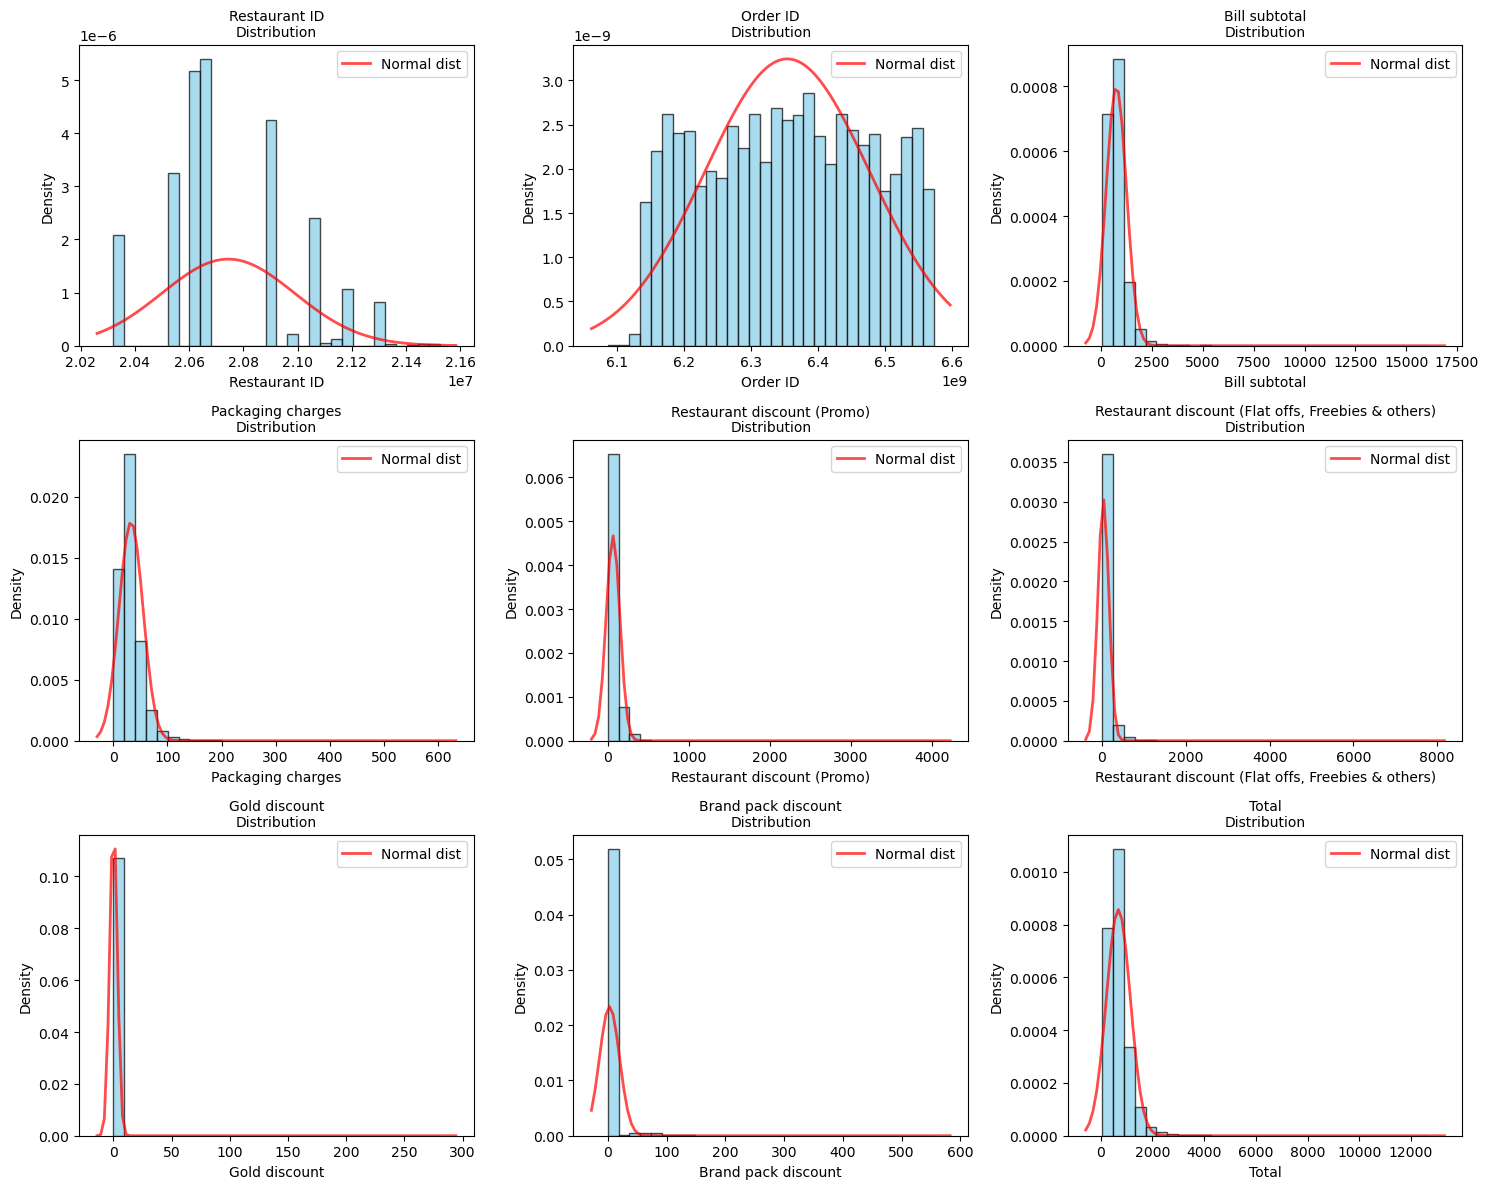

Summary
                                            Column  Shapiro_p_value  Is_Normal Recommended_Measure  Skewness           Mean         Median
                                     Restaurant ID            0.000      False              Median     0.543   20744129.124   20659868.000
                                          Order ID            0.000      False              Median    -0.016 6354622499.371 6357714982.000
                                     Bill subtotal            0.000      False              Median     5.941        750.077        629.000
                                 Packaging charges            0.000      False              Median     4.473         32.565         28.450
                       Restaurant discount (Promo)            0.000      False              Median     7.910         65.092         80.000
Restaurant discount (Flat offs, Freebies & others)            0.000      False              Median    13.961         31.795          0.000
                   

In [220]:
data_clean=data.copy()
numerical_cols=[col for col in data_clean.columns if (data_clean[col].dtype=='int64') | (data_clean[col].dtype=='float64')]
for col in numerical_cols:
    if col in data_clean.columns:
        data[col]=pd.to_numeric(data_clean[col], errors='coerce')

print("Normal Distribution Analysis:")
summary_data=[]
for col in numerical_cols:
    if col in data_clean.columns:
        col_data=data_clean[col].dropna()
        if len(col_data)>3:
            try:
                skewness=stats.skew(col_data)
                kurtosis=stats.kurtosis(col_data)
                stat, p_value=stats.shapiro(col_data)
                
                # Determine if normal
                is_normal=p_value>0.05
                measure_to_use="Mean" if is_normal else "Median"
                
                print(f"\n{col}:")
                print(f"Shapiro-Wilk p-value: {p_value:.4f}")
                print(f"Normal distribution: {'YES' if is_normal else 'NO'}")
                print(f"Recommended measure: {measure_to_use}")
                print(f"Skewness: {skewness:.4f} ({'symmetric' if abs(skewness)<0.5 else 'moderate skew' if abs(skewness)<1 else 'high skew'})")
                print(f"Kurtosis: {kurtosis:.4f}")
                print(f"Mean: {col_data.mean():.2f}, Median: {col_data.median():.2f}")
                print(f"Sample size: {len(col_data)}")
                
                summary_data.append({
                    'Column': col,
                    'Shapiro_p_value': p_value,
                    'Is_Normal': is_normal,
                    'Recommended_Measure': measure_to_use,
                    'Skewness': skewness,
                    'Mean': col_data.mean(),
                    'Median': col_data.median()
                })
                
            except Exception as e:
                print(f"\n{col}: Error in analysis-{e}")
        else:
            print(f"\n{col}: Not enough data for analysis (n={len(col_data)})")
    else:
        print(f"\n{col}: Column not found in cleaned data")

fig, axes=plt.subplots(3, 3, figsize=(15, 12))
axes=axes.ravel()

for i, col in enumerate(numerical_cols):
    if i<len(axes) and col in data_clean.columns:
        col_data=data_clean[col].dropna()
        if len(col_data)>0:
            axes[i].hist(col_data, bins=30, alpha=0.7, density=True, color='skyblue', edgecolor='black')
            axes[i].set_title(f'{col}\nDistribution', fontsize=10)
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Density')
            
            # Add normal distribution curve for comparison if we have enough data
            if len(col_data)>1:
                try:
                    from scipy.stats import norm
                    xmin, xmax=axes[i].get_xlim()
                    x = np.linspace(xmin, xmax, 100)
                    p = norm.pdf(x, col_data.mean(), col_data.std())
                    axes[i].plot(x, p, 'r', linewidth=2, label='Normal dist', alpha=0.7)
                    axes[i].legend()
                except:
                    pass

# Remove empty subplots if any
for i in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

print("Summary")
if summary_data:
    summary_df=pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False, float_format='%.3f'))
    mean_count=(summary_df['Recommended_Measure']=='Mean').sum()
    median_count=(summary_df['Recommended_Measure']=='Median').sum()
    print(f"\nFINAL RECOMMENDATION: Use Mean for {mean_count} columns, Median for {median_count} columns")
else:
    print("No summary data available")

**Normal dystribution**

We evaluated the distribution of all numerical columns using the Shapiro–Wilk test, skewness values and a comparison of mean and median. The goal was to determine the appropriate strategy for imputing missing values.

Short summarision:
- All numerical variables have Shapiro–Wilk p-values<0.05, indicating that none of the columns follow a normal distribution.
- Most variables exhibit high positive skewness, meaning the distributions are heavily right-tailed.
- In every case, the mean is substantially different from the median, further confirming non-normality and sensitivity to extreme values.

Since none of the numeric columns are normally distributed, the median is the most appropriate measure of central tendency.
Using the median ensures reduced impact of outliers, more stable feature values and better downstream model performance.

## Missing values

In [221]:
missing_count=data.isnull().sum()
missing_percent=(missing_count/len(data))*100
missing_analisis=pd.DataFrame({
    'column': data.columns,
    'missing_count': missing_count,
    'missing_percent': missing_percent
}).sort_values('missing_percent', ascending=False)
missing_analisis

,column,missing_count,missing_percent
Restaurant penalty (Rejection),Restaurant penalty (Rejection),21318,99.985929
Restaurant compensation (Cancellation),Restaurant compensation (Cancellation),21188,99.376202
Cancellation / Rejection reason,Cancellation / Rejection reason,21135,99.127621
Review,Review,21025,98.611697
Customer complaint tag,Customer complaint tag,20852,97.800291
Instructions,Instructions,20601,96.623048
Rating,Rating,18830,88.316683
Discount construct,Discount construct,5498,25.786783
KPT duration (minutes),KPT duration (minutes),295,1.383612
Rider wait time (minutes),Rider wait time (minutes),168,0.787956


We delete columns with high missing percentage (above 50%).
But there is an exeption. We fill column Instructions because if it is empty, we can just say that there was no special instruction.

We fill the rest with mean or with the appropriate text.

In [222]:
def missing_values_handling(data):
    data_clean=data.copy()
    actions={}
    high_missing=[
        'Restaurant penalty (Rejection)',
        'Restaurant compensation (Cancellation)',
        'Cancellation / Rejection reason',
        'Review',
        'Customer complaint tag',
        'Rating'
    ]

    for col in high_missing:
        if col in data_clean.columns:
            data_clean=data_clean.drop(columns=[col])
        actions[col]='Dropped'
                
    medium_missing={
        'Instructions': 'No special instructions',
        'Discount construct': 'No discount'
    }

    for col, strategy in medium_missing.items():
        if col in data.columns:
            if data_clean[col].dtype=='object':
                data_clean[col]=data_clean[col].fillna(strategy)
                actions[col]=f'Filled with {strategy}'
            else:
                value=data_clean[col].median()
                data_clean=data_clean[col].fillna(value)
                actions[col]=f'Filled with median: {value:.2f}'

    low_missing={
        'KPT duration (minutes)': 'Median',
        'Rider wait time (minutes)': 'Median'
    }

    for col, strategy in low_missing.items():
        if col in data.columns:
            if strategy=='Median':
                value=data_clean[col].median()
                data_clean[col]=data_clean[col].fillna(value)
                actions[col]=f'Filled with median: {value:.2f}'

    return data_clean, actions

In [223]:
data_cleaned, actions_done=missing_values_handling(data)

In [224]:
for col, action in actions_done.items():
    print(f"{col}: {action}")

Restaurant penalty (Rejection): Dropped
Restaurant compensation (Cancellation): Dropped
Cancellation / Rejection reason: Dropped
Review: Dropped
Customer complaint tag: Dropped
Rating: Dropped
Instructions: Filled with No special instructions
Discount construct: Filled with No discount
KPT duration (minutes): Filled with median: 16.33
Rider wait time (minutes): Filled with median: 3.10


In [225]:
print(f"Missing values before: {data.isnull().sum().sum()}")
print(f"Missing values after: {data_cleaned.isnull().sum().sum()}")

Missing values before: 150910
Missing values after: 0


In [226]:
data_cleaned

,Restaurant ID,Restaurant name,Subzone,City,Order ID,Order Placed At,Order Status,Delivery,Distance,Items in order,...,Packaging charges,Restaurant discount (Promo),"Restaurant discount (Flat offs, Freebies & others)",Gold discount,Brand pack discount,Total,KPT duration (minutes),Rider wait time (minutes),Order Ready Marked,Customer ID
0,20320607,Swaad,Sector 4,Delhi NCR,6168884918,"11:38 PM, September 10 2024",Delivered,Zomato Delivery,3km,"1 x Grilled Chicken Jamaican Tender, 1 x Grill...",...,31.75,80.0,0.0,0.0,0.0,666.75,18.35,11.6,Correctly,5d6c2b96db963098bc69768bea504c8bf46106a8a5178e...
1,20320607,Swaad,Sector 4,Delhi NCR,6170707559,"11:34 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Peri Peri Fries, 1 x Fried Chicken Angara ...",...,50.20,175.0,0.0,0.0,0.0,1054.20,16.95,3.6,Correctly,0781815deb4a10a574e9fee4fa0b86b074d4a0b36175d5...
2,20320607,Swaad,Sector 4,Delhi NCR,6169375019,"03:52 PM, September 10 2024",Delivered,Zomato Delivery,<1km,1 x Bone in Peri Peri Grilled Chicken,...,11.50,80.0,0.0,0.0,0.0,241.50,14.05,12.2,Correctly,f93362f5ce5382657482d164e368186bcec9c6225fd93d...
3,20320607,Swaad,Sector 4,Delhi NCR,6151677434,"03:45 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Fried Chicken Ghostbuster Tender, 1 x Anga...",...,27.00,80.0,0.0,0.0,0.0,567.00,19.00,3.3,Correctly,1ed226d1b8a5f7acee12fc1d6676558330a3b2b742af5d...
4,20320607,Swaad,Sector 4,Delhi NCR,6167540897,"03:04 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Peri Peri Krispers, 1 x Fried Chicken Anga...",...,25.20,80.0,0.0,0.0,0.0,529.20,15.97,1.0,Correctly,d21a2ac6ea06b31cc3288ab20c4ef2f292066c096f2c5f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21316,21467440,The Chicken Junction,Chittaranjan Park,Delhi NCR,6568490993,"03:26 AM, January 30 2025",Delivered,Zomato Delivery,5km,1 x Fried Chicken Desi Peri Peri Bites (Bone),...,21.00,90.0,0.0,0.0,0.0,441.00,14.32,9.0,Correctly,c6ee80eb35f2ef1630fd93ea88f8c0ac27eff57229a6d5...
21317,21467440,The Chicken Junction,Chittaranjan Park,Delhi NCR,6564842673,"02:44 AM, January 29 2025",Delivered,Zomato Delivery,5km,1 x Fried Chicken 65 Masala Boneless Bites,...,24.22,75.6,0.0,0.0,0.0,508.62,16.33,10.8,Missed,d2a0153ba6512894c1bebe974f6898ba10df50abc2c954...
21318,21523055,Masala Junction,Sector 4,Delhi NCR,6553527557,"10:05 PM, January 24 2025",Delivered,Zomato Delivery,8km,1 x Korean Fried Chicken Slider,...,21.50,0.0,0.0,0.0,0.0,451.50,16.27,9.4,Incorrectly,0b6168cbaf96aa5a0ae6b46d19d83ec9cad0d9508d43d7...
21319,21523055,Masala Junction,Sector 4,Delhi NCR,6541170157,"02:27 PM, January 21 2025",Delivered,Zomato Delivery,9km,1 x Ooh Saucy Fries,...,16.95,0.0,0.0,0.0,0.0,355.95,12.77,1.3,Correctly,410b3e056e511e3423d9497c629ca897f91cace2a2a732...


**Missing Value Treatment Overview**

A detailed inspection of missing values revealed that several columns contained high proportions of null entries or carried information that was unsuitable for imputation. Each variable was handled based on its type, usefulness and the feasibility of reconstructing missing information.

Columns that were removed due to extremely sparse data, lack ofanalytical value or their qualitative nature:
- Restaurant penalty (Rejection) 
- Restaurant compensation (Cancellation)
- Cancellation / Rejection reason
- Review
- Customer complaint tag
- Rating

These variables were either dominated by missing values, too subjective or inconsistent to impute reliably or not essential for the planned analysis.

Given the high level of sparsity and non-numeric content, imputation would have introduced noise rather than useful information.

Some categorical fields were missing but could be safely replaced with interpretable default values:

- Instructions -> "No special instructions"
- Discount construct -> "No discount"

These replacements preserve meaning while avoiding artificial patterns.

Two numerical operational metrics were missing but had non-normal distributions, so the median was used for robust imputation:
- KPT duration (minutes) -> median=16.33
- Rider wait time (minutes) -> median=3.10

Median values are preferred for skewed variables, as they reduce the impact of outliers and reflect the typical case more accurately than the mean.

All missing 150 910 entries have been appropriately handled and the dataset is now complete and ready for modeling or further analysis.


We parse the data to convert the date/time text strings into proper datetime objects, which allows us to extract useful components like dates, times and days of the week for analysis and visualization in Power BI.

In [227]:
def parse_datetime(dt_str):
    try:
        return datetime.strptime(dt_str, '%I:%M %p, %B %d %Y')
    except ValueError:
        return pd.NaT

data_cleaned['Parsed Date Time']=data_cleaned['Order Placed At'].apply(parse_datetime)

if data_cleaned['Parsed Date Time'].isna().any():
    print(f"Attention: {data_cleaned['Parsed Date Time'].isna().sum()} records were not parsed well")
else:
    print("Everything went well")

Everything went well


In [228]:
data_cleaned['Order Date']=data_cleaned['Parsed Date Time'].dt.date
data_cleaned['Order Time']=data_cleaned['Parsed Date Time'].dt.time
data_cleaned['Day']=data_cleaned['Parsed Date Time'].dt.day_name()

We make a column which describes the discount type.

In [229]:
def discount_type(discounts):
    if '%' in str(discounts):
        return 'Percentage off'
    elif 'Flat' in str(discounts):
        return 'Flat Off'
    elif 'No discount' in str(discounts):
        return 'No Discount'
    else:
        return 'Other Discount'
        

In [230]:
data_cleaned['Discount Type']=data_cleaned['Discount construct'].apply(discount_type)

We make a column to sum up all the discounts.

In [231]:
data_cleaned['Total Discount']=(
    data_cleaned['Restaurant discount (Promo)']+
    data_cleaned['Restaurant discount (Flat offs, Freebies & others)']+
    data_cleaned['Gold discount']+
    data_cleaned['Brand pack discount']
)

We made a column to see category of the distance.

In [232]:
def distance_category (distance):
    if distance=='<1km':
        return 'Below 1 km'
    elif isinstance(distance, str) and 'km' in distance:
        km=float(distance.replace('km', '').strip())
        return '1-3 km' if km<=3 else 'Above 3 km'
    else:
        return 'Unknown'

In [233]:
data_cleaned['Delivery Distance Category']=data_cleaned['Distance'].apply(distance_category)

In [234]:
data_cleaned=data_cleaned.drop('Parsed Date Time', axis=1)

print(data_cleaned[['Order Placed At', 'Order Date', 'Order Time', 'Day', 
            'Discount Type', 'Total Discount', 'Delivery Distance Category']].head(10))

               Order Placed At  Order Date Order Time      Day  \
0  11:38 PM, September 10 2024  2024-09-10   23:38:00  Tuesday   
1  11:34 PM, September 10 2024  2024-09-10   23:34:00  Tuesday   
2  03:52 PM, September 10 2024  2024-09-10   15:52:00  Tuesday   
3  03:45 PM, September 10 2024  2024-09-10   15:45:00  Tuesday   
4  03:04 PM, September 10 2024  2024-09-10   15:04:00  Tuesday   
5  12:28 PM, September 10 2024  2024-09-10   12:28:00  Tuesday   
6  12:03 AM, September 10 2024  2024-09-10   00:03:00  Tuesday   
7  10:54 PM, September 09 2024  2024-09-09   22:54:00   Monday   
8  10:51 PM, September 09 2024  2024-09-09   22:51:00   Monday   
9  03:22 PM, September 09 2024  2024-09-09   15:22:00   Monday   

    Discount Type  Total Discount Delivery Distance Category  
0  Percentage off            80.0                     1-3 km  
1        Flat Off           175.0                     1-3 km  
2  Percentage off            80.0                 Below 1 km  
3  Percentage off    

## Saving cleaned data to files and summary

In [235]:
data_cleaned.to_csv('../data/processed/final_data.csv', index=False)

In [236]:
data_cleaned.to_excel('../data/processed/data_to_powerBI.xlsx', index=False)

In [237]:
print("\nCleaning Summary")
print(f"\nFinal dataset shape: {data_cleaned.shape}")
print(f"\nColumns: {data_cleaned.columns.tolist()}")
print(f"\nData types:\n{data_cleaned.dtypes}")


Cleaning Summary

Final dataset shape: (21321, 29)

Columns: ['Restaurant ID', 'Restaurant name', 'Subzone', 'City', 'Order ID', 'Order Placed At', 'Order Status', 'Delivery', 'Distance', 'Items in order', 'Instructions', 'Discount construct', 'Bill subtotal', 'Packaging charges', 'Restaurant discount (Promo)', 'Restaurant discount (Flat offs, Freebies & others)', 'Gold discount', 'Brand pack discount', 'Total', 'KPT duration (minutes)', 'Rider wait time (minutes)', 'Order Ready Marked', 'Customer ID', 'Order Date', 'Order Time', 'Day', 'Discount Type', 'Total Discount', 'Delivery Distance Category']

Data types:
Restaurant ID                                           int64
Restaurant name                                        object
Subzone                                                object
City                                                   object
Order ID                                                int64
Order Placed At                                        object
Order 

In [238]:
print("Basic Statistics")
print(data_cleaned.describe(include='all'))
print("\nFirst 5 rows of cleaned data")
print(data_cleaned.head())

Basic Statistics
        Restaurant ID Restaurant name                  Subzone       City  \
count    2.132100e+04           21321                    21321      21321   
unique            NaN               6                        8          1   
top               NaN     Aura Pizzas  Greater Kailash 2 (GK2)  Delhi NCR   
freq              NaN           14548                     7380      21321   
mean     2.074413e+07             NaN                      NaN        NaN   
std      2.447193e+05             NaN                      NaN        NaN   
min      2.032061e+07             NaN                      NaN        NaN   
25%      2.063570e+07             NaN                      NaN        NaN   
50%      2.065987e+07             NaN                      NaN        NaN   
75%      2.088265e+07             NaN                      NaN        NaN   
max      2.152306e+07             NaN                      NaN        NaN   

            Order ID             Order Placed At Order Sta

## Summary of the Cleaned Dataset

The final cleaned dataset consists of 21 321 rows and 29 columns, containing customer, restaurant and order-level information. All column names were standardized and their data types were verified to ensure consistency across numerical, categorical and datetime variables. Key fields include restaurant identifiers, location details, order timestamps, discounts, delivery metrics, dishes and customer information.

The dataset now contains the following columns:
Restaurant ID, Restaurant name, Subzone, City, Order ID, Order Placed At, Order Status, Delivery, Distance, Items in order, Instructions, Discount construct, Bill subtotal, Packaging charges, Restaurant discount (Promo), Restaurant discount (Flat offs, Freebies & others), Gold discount, Brand pack discount, Total, KPT duration (minutes), Rider wait time (minutes), Order Ready Marked, Customer ID, Order Date, Order Time, Day, Discount Type, Total Discount, Is Order Ready Correctly, Order Preparation Time, Delivery Distance Category, Items count, Items per Order Category.

Data types were validated, with numerical attributes converted to appropriate numeric formats and object fields cleaned for consistency.

The dataset was thoroughly cleaned and prepared for downstream analysis. The following transformations were applied:

- Initial inspection of dataset structure, dimensions and variable types.

- Text standardization, including removal of leading/trailing spaces and normalization of string fields.

- Handling of missing values through a custom function that applied suitable imputation based on column characteristics.

- Data type corrections to ensure proper interpretation of numerical and categorical fields.

- Integrity checks confirming that no missing values remain in critical columns and that distributions remain consistent.

- Addition of new columns which will be helpful to further analisis.

- Export of the cleaned dataset in both CSV and Excel formats for further analytics and BI workflows.

Overall, the cleaned dataset is consistent, reliable and ready for exploratory data analysis, visualization or machine-learning tasks.